In [1]:
########################################
# Packages
########################################
import warnings
import h5py as h5
import numpy as np
import pandas as pd
import multiprocessing as mp

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import math

import statistics

from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic
import scipy.stats.distributions as dist

import seaborn as sns

In [2]:
from data_processing import SHARKDataProcessor
processor = SHARKDataProcessor()

# Define subvolume IDs and HDF5 file paths
sv_list = np.arange(64)
sharkfiles = [f'extracted_data_z=0/199/{sv}/galaxies.hdf5' for sv in sv_list] #DEFINE FILE

# Output shark_csv dataframe
shark_csv = processor.process_all_subvolumes(sv_list, sharkfiles)
print(shark_csv.head())

  ID_galaxy ID_subhalo    ID_subhalo_tree ID_halo  sv  type    Mhalo_host  \
0   0_12323        0_1  0_199000000000184     0_1   0     0  1.553645e+12   
1   0_41884        0_2  0_199000000032613     0_1   0     1  1.553645e+12   
2   0_25337        0_4  0_199000000000239     0_2   0     0  1.013176e+12   
3   0_12324        0_4  0_199000000000239     0_2   0     2  1.013176e+12   
4  0_325815        0_5  0_199000000032723     0_2   0     1  1.013176e+12   

          Mhalo   Mstar_bulge    Mstar_disc  ...  SFR_bulge  SFR_disc  \
0  1.406334e+12  4.406725e+10  8.090279e+09  ...   0.239161  8.448190   
1  1.132662e+11  6.663850e+07  3.927870e+08  ...   0.000000  0.045958   
2  7.889350e+11  1.441911e+10  7.342129e+06  ...   5.469577  0.054259   
3  4.321138e+10  4.237961e+08  9.966004e+08  ...   0.000000  0.128186   
4  2.242409e+11  4.860634e+08  7.437644e+08  ...   0.000000  0.316807   

    SFR_all           MBH  MBHacc_cold    MBHacc_hot    MBHacc_all  \
0  8.687351  2.992633e+07   

In [3]:
########################################
# gal_sv settings
########################################
# type: galaxy type; =0 for centrals; =1 for satellites that reside in well identified subhalos; =2 for orphan satellites

shark_csv_centrals = shark_csv[(shark_csv['type'] == 0)] ######## Centrals only
shark_csv_satellites = shark_csv[(shark_csv['type'] == 1)] ######## Satellites only
shark_csv_satANDor = shark_csv[(shark_csv['type'].isin([1, 2]))] ######## Satellites and Orphans

########################################
# Late and Early Type Galaxies
########################################
valid_data = shark_csv['Mstar_all'] > 0

shark_csv_late = (shark_csv['Mstar_disc'] / shark_csv['Mstar_all'] > 0.5) & valid_data  # Late-Type Galaxies (D/T > 0.5)
shark_csv_early = (shark_csv['Mstar_disc'] / shark_csv['Mstar_all'] <= 0.5) & valid_data  # Early-Type Galaxies (D/T <= 0.5)

bin_medians: [0.01013983 0.0053878  0.0021602  0.00285382 0.00578228 0.0141957
 0.02694881 0.01515239 0.01142444 0.00951415 0.00859169 0.00746539
 0.00663614 0.00579824 0.0046551  0.00336142] bin medians number 16

Processing Bin 1/16:
  - Bin Range: 1.00e+10 to 2.05e+10
  - Number of galaxies in bin: 11059
  - Min SHMR in bin: 4.929e-03, Max SHMR in bin: 2.532e+00
  - Bin Median SHMR: 1.014e-02
  - Min Residual: -0.313, Max Residual: 2.397

Processing Bin 2/16:
  - Bin Range: 2.05e+10 to 4.22e+10
  - Number of galaxies in bin: 34793
  - Min SHMR in bin: 2.390e-03, Max SHMR in bin: 1.301e+00
  - Bin Median SHMR: 5.388e-03
  - Min Residual: -0.353, Max Residual: 2.383

Processing Bin 3/16:
  - Bin Range: 4.22e+10 to 8.66e+10
  - Number of galaxies in bin: 192317
  - Min SHMR in bin: 1.162e-03, Max SHMR in bin: 1.146e+00
  - Bin Median SHMR: 2.160e-03
  - Min Residual: -0.269, Max Residual: 2.725

Processing Bin 4/16:
  - Bin Range: 8.66e+10 to 1.78e+11
  - Number of galaxies in bin: 237

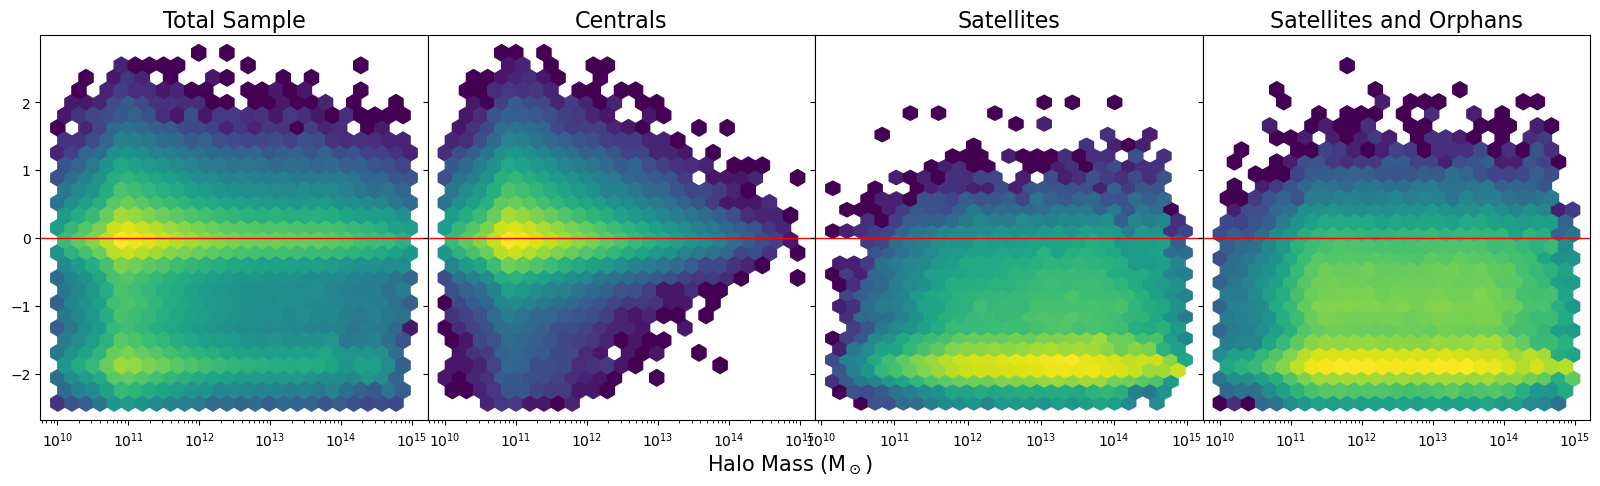

In [27]:
########################################
# RESIDUALS density plot (SHMR vs Halo Mass) OG
########################################
# Subplot controls
datasets = [("Total Sample", shark_csv), 
            ("Centrals", shark_csv_centrals), 
            ("Satellites", shark_csv_satellites), 
            ("Satellites and Orphans", shark_csv_satANDor)]

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.subplots_adjust(wspace=0)

########################################
# Residual line - HALO MASS vs. SHMR for CENTRALS
########################################
# The ultimate output of this code are the bin edges, x values for the bins, and the bin medians FOR CENTRALS
# This SHMR calculation needs to find SHMR for just centrals, our residual line is centrals only.
SHMR_threshold = 10**-4
SHMR = shark_csv_centrals['Mstar_all'] / shark_csv_centrals['Mhalo_host'] 
SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)

#print('len centrals Mstar_all:', len(shark_csv_centrals['Mstar_all']))
#print('len centrals Mhalo_host:', len(shark_csv_centrals['Mhalo_host']))
#rint('len SHMR for centrals:',len(SHMR))

# Calculate min and max log values of Mhalo_host for centrals
lowLog = math.log10(shark_csv_centrals['Mhalo_host'].min())
highLog = math.log10(shark_csv_centrals['Mhalo_host'].max())

# Round to the nearest whole number for log binning
lowLog = round(lowLog, 0)
highLog = round(highLog, 0)

# Create log bins
num_bins = 16
logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

# MEDIAN for y-values (SHMR) using centrals data
result = binned_statistic(
    shark_csv_centrals['Mhalo_host'],
    SHMR,
    statistic='median',
    bins=logBins
)
bin_medians = result.statistic

# Calculate xVals by finding the median Mhalo_host value within each bin
xVals = []
for j in range(len(logBins) - 1):
    # Filter data points within the current bin
    bin_data = shark_csv_centrals['Mhalo_host'][
        (shark_csv_centrals['Mhalo_host'] >= logBins[j]) & 
        (shark_csv_centrals['Mhalo_host'] < logBins[j + 1])
    ]
    if len(bin_data) > 0:
        # Append the median of Mhalo_host values in the bin to xVals
        xVals.append(np.median(bin_data))
    else:
        # If no data points in the bin, append NaN
        xVals.append(np.nan)
        print('nan appended')

# Convert xVals to a numpy array and remove NaN values (if necessary)
xVals = np.array(xVals)
valid_bins = ~np.isnan(xVals)
xVals = xVals[valid_bins]
bin_medians = bin_medians[valid_bins]

#print('xVals:', xVals, 'xVals number:', len(xVals))
#print('bin edges:', logBins, 'bin edges number:', len(logBins))
print('bin_medians:', bin_medians, 'bin medians number', len(bin_medians))

########################################

#print('length data Mstar_all:', len(data['Mstar_all']))
#print('length data Mhalo_host:', len(data['Mhalo_host']))
#print('length SHMR_univ:', len(SHMR_univ))

# Loop through each dataset and create a plot
for i, (title, data) in enumerate(datasets):  # its looking at data, not shark_csv_centrals. 

    # New SHMR calculation. Not for centrals, for general use.
    SHMR_threshold_univ = 10**-4
    SHMR_univ = data['Mstar_all'] / data['Mhalo_host'] 
    SHMR_univ = np.where(SHMR_univ < SHMR_threshold_univ, SHMR_threshold_univ, SHMR_univ)

    residuals = []
    dex_residuals = []

    # Iterate over bins to compute residuals
    for j in range(len(logBins) - 1):
        # Filter halo masses within the current bin using a mask bin_indices
        bin_indices = (data['Mhalo_host'] >= logBins[j]) & \
                      (data['Mhalo_host'] < logBins[j + 1])
        bin_data = SHMR_univ[bin_indices]  # extract values corresponding to Mhalo_host values within the current bin

        # Debug: Print bin range and number of galaxies in the bin
        print(f"\nProcessing Bin {j+1}/{len(logBins)-1}:")
        print(f"  - Bin Range: {logBins[j]:.2e} to {logBins[j+1]:.2e}")
        print(f"  - Number of galaxies in bin: {len(bin_data)}")
        
        if len(bin_data) > 0:  # Will not calculate residual of empty bins
            current_residuals = np.log10(bin_data) - np.log10(bin_medians[j]) # measurable variable - approximate variable
            #print(f"Dataset {title}: residuals Min={current_residuals.min():.3f}, Max={current_residuals.max():.3f}")

            # Debug: Print min/max values in bin and residuals
            print(f"  - Min SHMR in bin: {bin_data.min():.3e}, Max SHMR in bin: {bin_data.max():.3e}")
            print(f"  - Bin Median SHMR: {bin_medians[j]:.3e}")
            print(f"  - Min Residual: {current_residuals.min():.3f}, Max Residual: {current_residuals.max():.3f}")
            
            # Replace zeros with a small value to avoid log10(0)
            current_residuals[current_residuals == 0] = 1e-10
            
            residuals.extend(current_residuals)
            #dex_residuals.extend(dex_current_residuals)
        else:
            print("bin error: empty bin")
    
    # Convert residuals to numpy array
    residuals = np.array(residuals)
    dex_residuals = np.array(dex_residuals)
    x_residuals = data['Mhalo_host'][data['Mhalo_host'] >= logBins[0]]
    print(f"x_residuals shape: {x_residuals.shape}, dex_residuals shape: {dex_residuals.shape}, residuals shape: {residuals.shape}")

    #axs[i].scatter(x_residuals, residuals, color='blue', alpha=0.01, label='DEX Residuals')

    axs[i].hexbin(x_residuals, residuals, gridsize=25, xscale = 'log', yscale = 'linear', cmap='viridis', mincnt=1, bins='log')
    axs[i].axhline(y=0, color='red', linewidth=1)
    
    # Set titles and adjust scales
    axs[i].set_title(f'{title}', fontsize=16)
    axs[i].set_xscale('log')  # Keep x-axis logarithmic
    axs[i].set_yscale('linear')  # Use linear scale for dex values

# Add a single x-axis and y-axis label
fig.text(0.5, 0.01, r'Halo Mass (M$_\odot$)', ha='center', fontsize=15)

plt.show()

In [29]:
print(residuals.__len__())

221218


xVals: [1.60405861e+10 3.27358921e+10 6.90727270e+10 1.17849207e+11
 2.40608808e+11 4.94639294e+11 1.01579470e+12 2.07987480e+12
 4.27759869e+12 8.71625810e+12 1.77410532e+13 3.62468167e+13
 7.35778588e+13 1.47089898e+14 2.94630354e+14 6.39138419e+14] xVals number: 16
bin_medians: [0.01013983 0.0053878  0.0021602  0.00285382 0.00578228 0.0141957
 0.02694881 0.01515239 0.01142444 0.00951415 0.00859169 0.00746539
 0.00663614 0.00579824 0.0046551  0.00336142] bin medians number 16
x_residuals shape: (704653,), dex_residuals shape: (0,), residuals shape: (704653,)
x_residuals shape: (122613,), dex_residuals shape: (0,), residuals shape: (122613,)


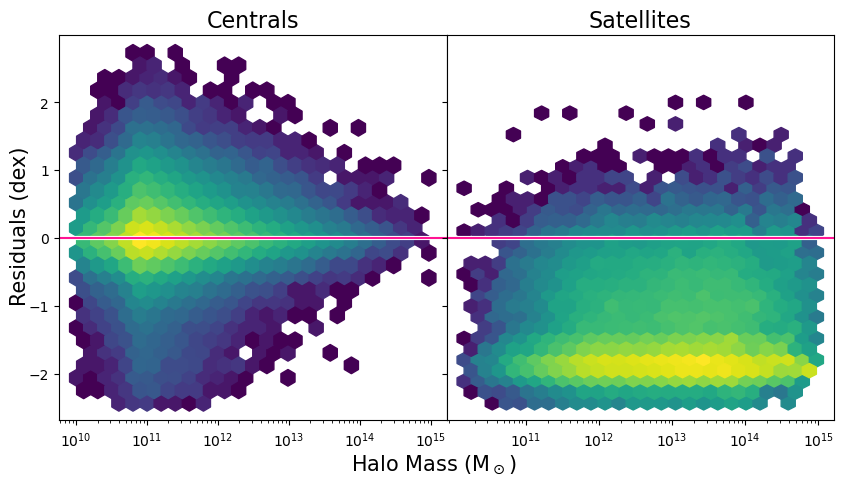

In [5]:
########################################
# RESIDUALS density plot (SHMR vs Halo Mass) Centrals and Sat only
########################################
# Subplot controls
datasets = [("Centrals", shark_csv_centrals), 
            ("Satellites", shark_csv_satellites)]

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
fig.subplots_adjust(wspace=0)

default_ticks = [10**10, 10**11, 10**12, 10**13, 10**14, 10**15]
########################################
# Residual line - HALO MASS vs. SHMR for CENTRALS
########################################
# The ultimate output of this code are the bin edges, x values for the bins, and the bin medians FOR CENTRALS
# This SHMR calculation needs to find SHMR for just centrals, our residual line is centrals only.
SHMR_threshold = 10**-4
SHMR = shark_csv_centrals['Mstar_all'] / shark_csv_centrals['Mhalo_host'] 
SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)

#print('len centrals Mstar_all:', len(shark_csv_centrals['Mstar_all']))
#print('len centrals Mhalo_host:', len(shark_csv_centrals['Mhalo_host']))
#rint('len SHMR for centrals:',len(SHMR))

# Calculate min and max log values of Mhalo_host for centrals
lowLog = math.log10(shark_csv_centrals['Mhalo_host'].min())
highLog = math.log10(shark_csv_centrals['Mhalo_host'].max())

# Round to the nearest whole number for log binning
lowLog = round(lowLog, 0)
highLog = round(highLog, 0)

# Create log bins
num_bins = 16
logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

# MEDIAN for y-values (SHMR) using centrals data
result = binned_statistic(
    shark_csv_centrals['Mhalo_host'],
    SHMR,
    statistic='median',
    bins=logBins
)
bin_medians = result.statistic

# Calculate xVals by finding the median Mhalo_host value within each bin
xVals = []
for j in range(len(logBins) - 1):
    # Filter data points within the current bin
    bin_data = shark_csv_centrals['Mhalo_host'][
        (shark_csv_centrals['Mhalo_host'] >= logBins[j]) & 
        (shark_csv_centrals['Mhalo_host'] < logBins[j + 1])
    ]
    if len(bin_data) > 0:
        # Append the median of Mhalo_host values in the bin to xVals
        xVals.append(np.median(bin_data))
    else:
        # If no data points in the bin, append NaN
        xVals.append(np.nan)
        print('nan appended')

# Convert xVals to a numpy array and remove NaN values (if necessary)
xVals = np.array(xVals)
valid_bins = ~np.isnan(xVals)
xVals = xVals[valid_bins]
bin_medians = bin_medians[valid_bins]

print('xVals:', xVals, 'xVals number:', len(xVals))
#print('bin edges:', logBins, 'bin edges number:', len(logBins))
print('bin_medians:', bin_medians, 'bin medians number', len(bin_medians))

########################################

#print('length data Mstar_all:', len(data['Mstar_all']))
#print('length data Mhalo_host:', len(data['Mhalo_host']))
#print('length SHMR_univ:', len(SHMR_univ))

# Loop through each dataset and create a plot
for i, (title, data) in enumerate(datasets):  # its looking at data, not shark_csv_centrals. 

    # New SHMR calculation. Not for centrals, for general use.
    SHMR_threshold_univ = 10**-4
    SHMR_univ = data['Mstar_all'] / data['Mhalo_host'] 
    SHMR_univ = np.where(SHMR_univ < SHMR_threshold_univ, SHMR_threshold_univ, SHMR_univ)

    residuals = []
    dex_residuals = []

    # Iterate over bins to compute residuals
    for j in range(len(logBins) - 1):
        # Filter halo masses within the current bin using a mask bin_indices
        bin_indices = (data['Mhalo_host'] >= logBins[j]) & \
                      (data['Mhalo_host'] < logBins[j + 1])
        bin_data = SHMR_univ[bin_indices]  # extract values corresponding to Mhalo_host values within the current bin
        
        if len(bin_data) > 0:  # Will not calculate residual of empty bins
            current_residuals = np.log10(bin_data) - np.log10(bin_medians[j]) # measurable variable - approximate variable
            #print(f"Dataset {title}: residuals Min={current_residuals.min():.3f}, Max={current_residuals.max():.3f}")

            # Replace zeros with a small value to avoid log10(0)
            current_residuals[current_residuals == 0] = 1e-10
            
            residuals.extend(current_residuals)
            #dex_residuals.extend(dex_current_residuals)
        else:
            print("bin error: empty bin")
    
    # Convert residuals to numpy array
    residuals = np.array(residuals)
    dex_residuals = np.array(dex_residuals)
    x_residuals = data['Mhalo_host'][data['Mhalo_host'] >= logBins[0]]
    print(f"x_residuals shape: {x_residuals.shape}, dex_residuals shape: {dex_residuals.shape}, residuals shape: {residuals.shape}")

    #axs[i].scatter(x_residuals, residuals, color='blue', alpha=0.01, label='DEX Residuals')

    axs[i].hexbin(x_residuals, residuals, gridsize=25, xscale = 'log', yscale = 'linear', cmap='viridis', mincnt=1, bins='log')
    axs[i].axhline(y=0, color='white', linewidth=3)
    axs[i].axhline(y=0, color='deeppink', linewidth=1.5)
    
    # Set titles and adjust scales
    axs[i].set_title(f'{title}', fontsize=16)
    axs[i].set_xscale('log')  # Keep x-axis logarithmic
    axs[i].set_yscale('linear')  # Use linear scale for dex values

    # Apply custom x-ticks only to the second plot
    if i == 1:
        axs[i].set_xticks(default_ticks[1:])  # Omitting 10^10
    else:
        axs[i].set_xticks(default_ticks)

# Add a single x-axis and y-axis label
fig.text(0.5, 0.01, r'Halo Mass (M$_\odot$)', ha='center', fontsize=15)
fig.text(0.076, 0.5, 'Residuals (dex)', va='center', rotation='vertical', fontsize=15)

plt.show()

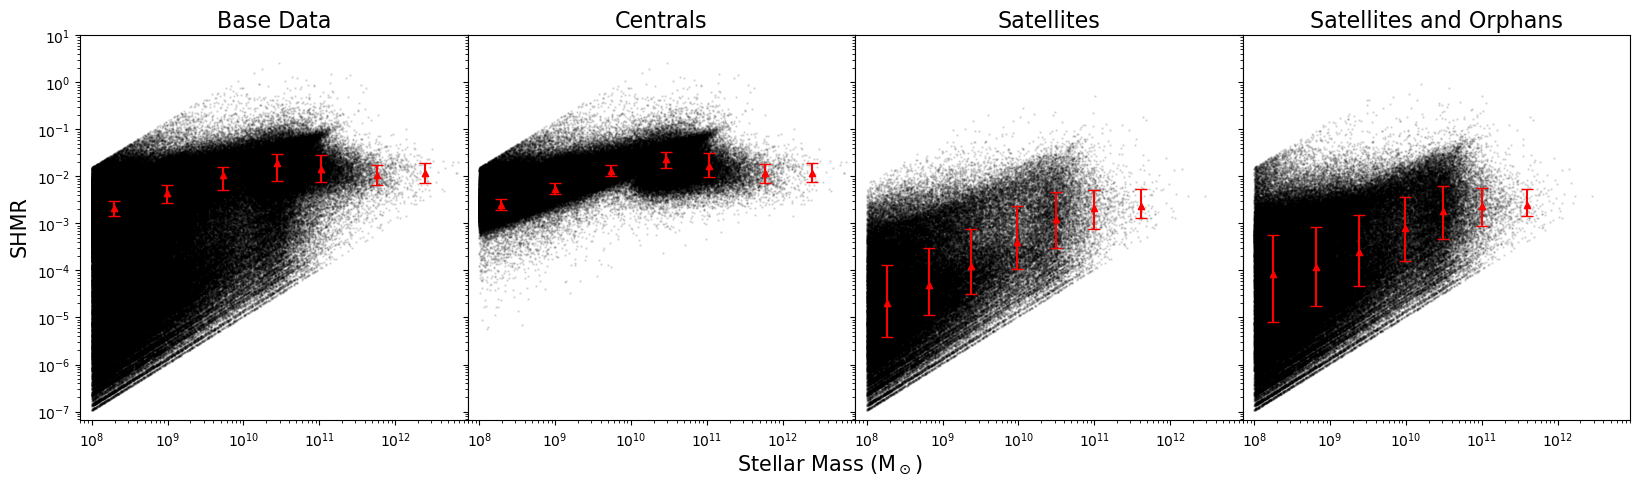

In [6]:
########################################
# Scatter Plots (SHMR vs STELLAR Mass)
########################################
# List of datasets for easy iteration
datasets = [("Base Data", shark_csv), 
            ("Centrals", shark_csv_centrals), 
            ("Satellites", shark_csv_satellites), 
            ("Satellites and Orphans", shark_csv_satANDor)]

SHMR_threshold = 10**-7

# Create a 1x4 grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.subplots_adjust(wspace=0)

# Set a shared x and y-axis range
y_min = 6.5*10**-8
y_max = 10
x_min = 7*10**7
x_max = 9*10**12

# Apply this range and ticks to all subplots
for ax in axs:
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([x_min, x_max])
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())  # Use scalar format for readability

# Loop through each dataset and create a plot
for i, (title, data) in enumerate(datasets):

    SHMR = data['Mstar_all'] / data['Mhalo_host']
    SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)
    
    # Calculate min and max log values of Mhalo_host
    lowLog = math.log10(data['Mstar_all'].min())
    highLog = math.log10(data['Mstar_all'].max())

    # Round to the nearest whole number for log binning
    lowLog = round(lowLog, 0)
    highLog = round(highLog, 0)

    # Create log bins
    num_bins = 7
    logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

    # MEDIAN for y-values
    result = binned_statistic(data['Mstar_all'], SHMR, statistic='median', bins=logBins)
    bin_medians = result.statistic

    # Calculate xVals by finding the median Mhalo_host value within each bin
    xVals = []
    for j in range(len(logBins) - 1):
        # Filter data points within the current bin
        bin_data = data['Mstar_all'][(data['Mstar_all'] >= logBins[j]) & (data['Mstar_all'] < logBins[j+1])]
        if len(bin_data) > 0:
            # Append the median of Mhalo_host values in the bin to xVals
            xVals.append(np.median(bin_data))
        else:
            # If no data points in the bin, append NaN or skip
            xVals.append(np.nan)

    # Convert xVals to a numpy array and remove NaN values (if necessary)
    xVals = np.array(xVals)
    valid_bins = ~np.isnan(xVals)
    xVals = xVals[valid_bins]
    bin_medians = bin_medians[valid_bins]

    # PERCENTILES
    # 25th percentile
    percentile_25 = binned_statistic(data['Mstar_all'], SHMR, statistic=lambda values: np.percentile(values, 25), bins=logBins)
    p25 = percentile_25.statistic[valid_bins]
    # 75th percentile
    percentile_75 = binned_statistic(data['Mstar_all'], SHMR, statistic=lambda values: np.percentile(values, 75), bins=logBins)
    p75 = percentile_75.statistic[valid_bins]

    # Plot on the current subplot
    axs[i].scatter(data['Mstar_all'], SHMR, s=0.8, alpha=0.1, color='black')
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlim([x_min, x_max])
    axs[i].set_ylim([y_min, y_max])
    
    # Bin plotting
    axs[i].scatter(xVals, bin_medians, s=20, color='red', marker="^")
    axs[i].errorbar(xVals, bin_medians, yerr=[bin_medians - p25, p75 - bin_medians], fmt='none', ecolor='red', capsize=4)

    # Set titles and remove y-axis labels for intermediate plots
    axs[i].set_title(f'{title}', fontsize=16)

# Add a single x-axis and y-axis label
fig.text(0.5, 0.01, r'Stellar Mass (M$_\odot$)', ha='center', fontsize=15)
fig.text(0.09, 0.5, 'SHMR', va='center', rotation='vertical', fontsize=15)

plt.show()

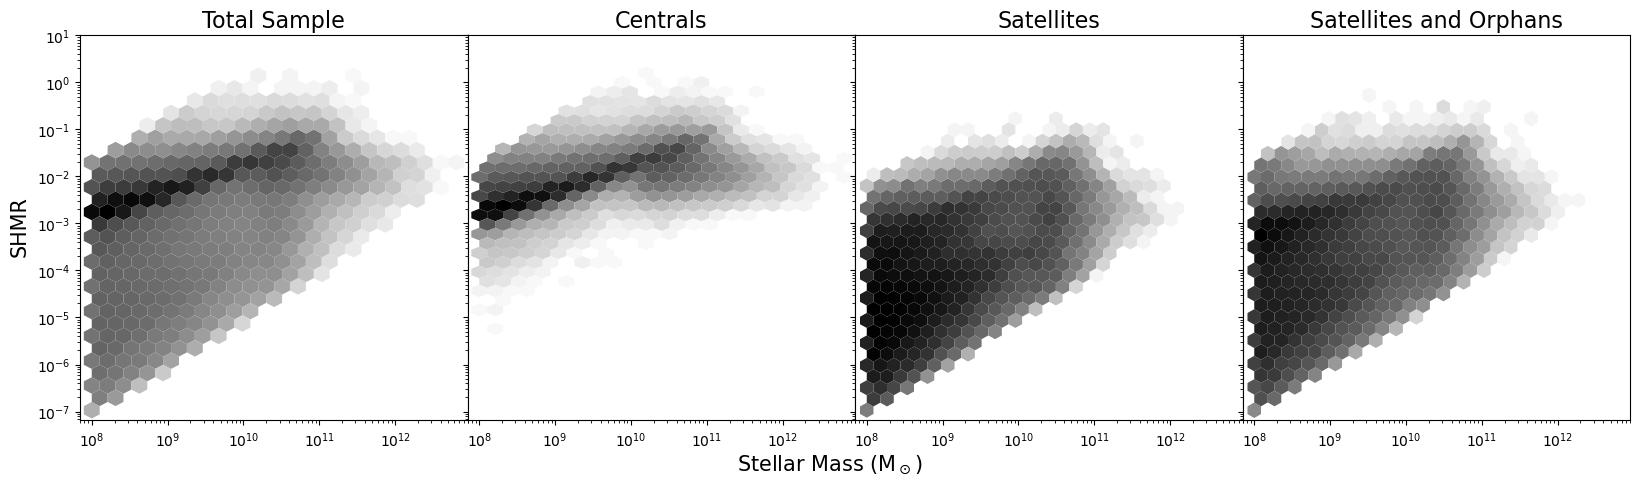

In [7]:
########################################
# Density Plots (SHMR vs STELLAR Mass)
########################################
# List of datasets for easy iteration
datasets = [("Total Sample", shark_csv), 
            ("Centrals", shark_csv_centrals), 
            ("Satellites", shark_csv_satellites), 
            ("Satellites and Orphans", shark_csv_satANDor)]

SHMR_threshold = 10**-7

# Create a 1x4 grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.subplots_adjust(wspace=0)

# Set a shared x and y-axis range
y_min = 6.5*10**-8
y_max = 10
x_min = 7*10**7
x_max = 9*10**12

# Apply this range and ticks to all subplots
for ax in axs:
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([x_min, x_max])
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())  # Use scalar format for readability

# Loop through each dataset and create a plot
for i, (title, data) in enumerate(datasets):

    SHMR = data['Mstar_all'] / data['Mhalo_host']
    SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)

    # Plot on the current subplot
    axs[i].hexbin(data['Mstar_all'], SHMR, gridsize=25, xscale='log', yscale='log',
                       reduce_C_function=np.sum, mincnt=1, bins='log', linewidth=0, cmap='Greys')
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlim([x_min, x_max])
    axs[i].set_ylim([y_min, y_max])

    # Set titles and remove y-axis labels for intermediate plots
    axs[i].set_title(f'{title}', fontsize=16)

# Add a single x-axis and y-axis label
fig.text(0.5, 0.01, r'Stellar Mass (M$_\odot$)', ha='center', fontsize=15)
fig.text(0.09, 0.5, 'SHMR', va='center', rotation='vertical', fontsize=15)

plt.show()

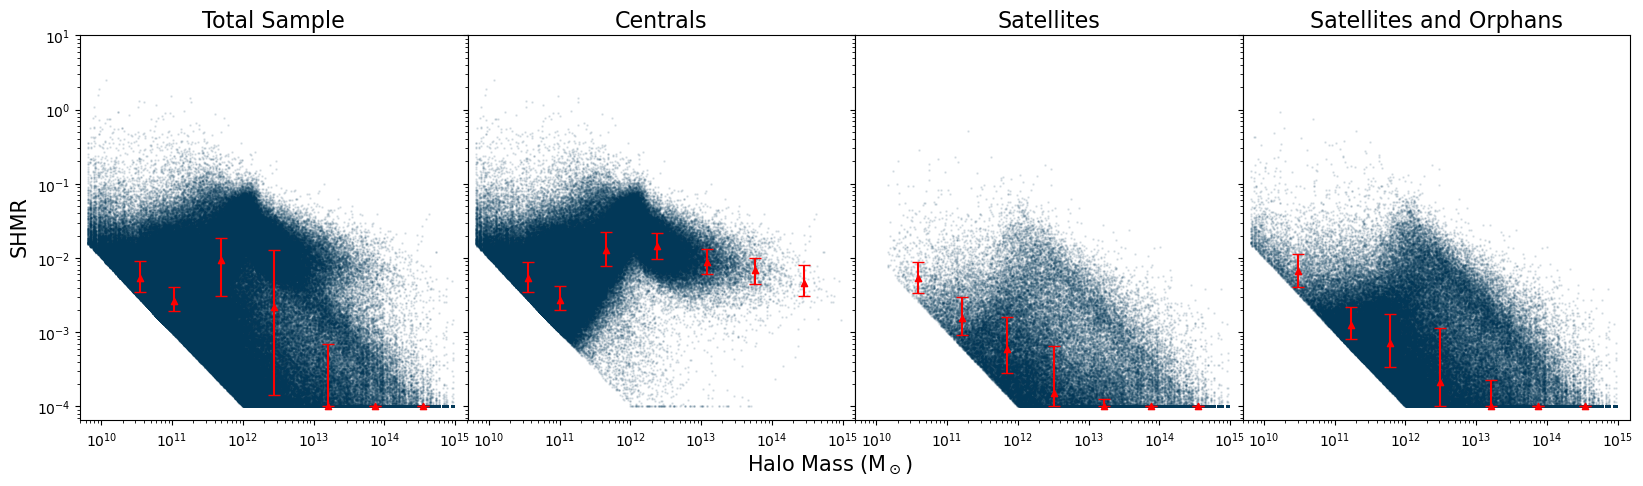

In [8]:
########################################
# Scatter Plots (SHMR vs Halo Mass)
########################################
# List of datasets for easy iteration
datasets = [("Total Sample", shark_csv), 
            ("Centrals", shark_csv_centrals), 
            ("Satellites", shark_csv_satellites), 
            ("Satellites and Orphans", shark_csv_satANDor)]

SHMR_threshold = 10**-4

# Create a 1x4 grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.subplots_adjust(wspace=0)

# Set a shared x and y-axis range
y_min = 6.5*10**-5
y_max = 10
x_min = 5*10**9
x_max = 1.5*10**15

# Apply this range and ticks to all subplots
for ax in axs:
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([x_min, x_max])
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())  # Use scalar format for readability

# Loop through each dataset and create a plot
for i, (title, data) in enumerate(datasets):

    SHMR = data['Mstar_all'] / data['Mhalo_host']
    SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)
    
    # Calculate min and max log values of Mhalo_host
    lowLog = math.log10(data['Mhalo_host'].min())
    highLog = math.log10(data['Mhalo_host'].max())

    # Round to the nearest whole number for log binning
    lowLog = round(lowLog, 0)
    highLog = round(highLog, 0)

    # Create log bins
    num_bins = 7
    logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

    # MEDIAN for y-values
    result = binned_statistic(data['Mhalo_host'], SHMR, statistic='median', bins=logBins)
    bin_medians = result.statistic

    # Calculate xVals by finding the median Mhalo_host value within each bin
    xVals = []
    for j in range(len(logBins) - 1):
        # Filter data points within the current bin
        bin_data = data['Mhalo_host'][(data['Mhalo_host'] >= logBins[j]) & (data['Mhalo_host'] < logBins[j+1])]
        if len(bin_data) > 0:
            # Append the median of Mhalo_host values in the bin to xVals
            xVals.append(np.median(bin_data))
        else:
            # If no data points in the bin, append NaN or skip
            xVals.append(np.nan)

    # Convert xVals to a numpy array and remove NaN values (if necessary)
    xVals = np.array(xVals)
    valid_bins = ~np.isnan(xVals)
    xVals = xVals[valid_bins]
    bin_medians = bin_medians[valid_bins]

    # PERCENTILES
    # 25th percentile
    percentile_25 = binned_statistic(data['Mhalo_host'], SHMR, statistic=lambda values: np.percentile(values, 25), bins=logBins)
    p25 = percentile_25.statistic[valid_bins]
    # 75th percentile
    percentile_75 = binned_statistic(data['Mhalo_host'], SHMR, statistic=lambda values: np.percentile(values, 75), bins=logBins)
    p75 = percentile_75.statistic[valid_bins]

    # Plot on the current subplot
    axs[i].scatter(data['Mhalo_host'], SHMR, s=0.8, alpha=0.1, color='#023858')
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlim([x_min, x_max])
    axs[i].set_ylim([y_min, y_max])
    
    # Bin plotting
    axs[i].scatter(xVals, bin_medians, s=20, color='red', marker="^")
    axs[i].errorbar(xVals, bin_medians, yerr=[bin_medians - p25, p75 - bin_medians], fmt='none', ecolor='red', capsize=4)

    # Set titles and remove y-axis labels for intermediate plots
    axs[i].set_title(f'{title}', fontsize=16)

# Add a single x-axis and y-axis label
fig.text(0.5, 0.01, r'Halo Mass (M$_\odot$)', ha='center', fontsize=15)
fig.text(0.09, 0.5, 'SHMR', va='center', rotation='vertical', fontsize=15)

plt.show()

In [9]:
########## SHMR CSV (BEHROOZI 2019 UniverseMachine)
file_path2 = "Behroozi.csv"

SHMRline = pd.read_csv(file_path2, header=None)
SHMRline.columns = ["Column1", "Column2"]
SHMRline = 10 ** SHMRline

SHMRline = SHMRline.sort_values(by="Column1").reset_index(drop=True)

########## SHMR CSV (BEHROOZI 2013)
file_path3 = "BH2013.csv"

SHMRline2 = pd.read_csv(file_path3, header=None)
SHMRline2.columns = ["Column1", "Column2"]
SHMRline2 = 10 ** SHMRline2

SHMRline2 = SHMRline2.sort_values(by="Column1").reset_index(drop=True)

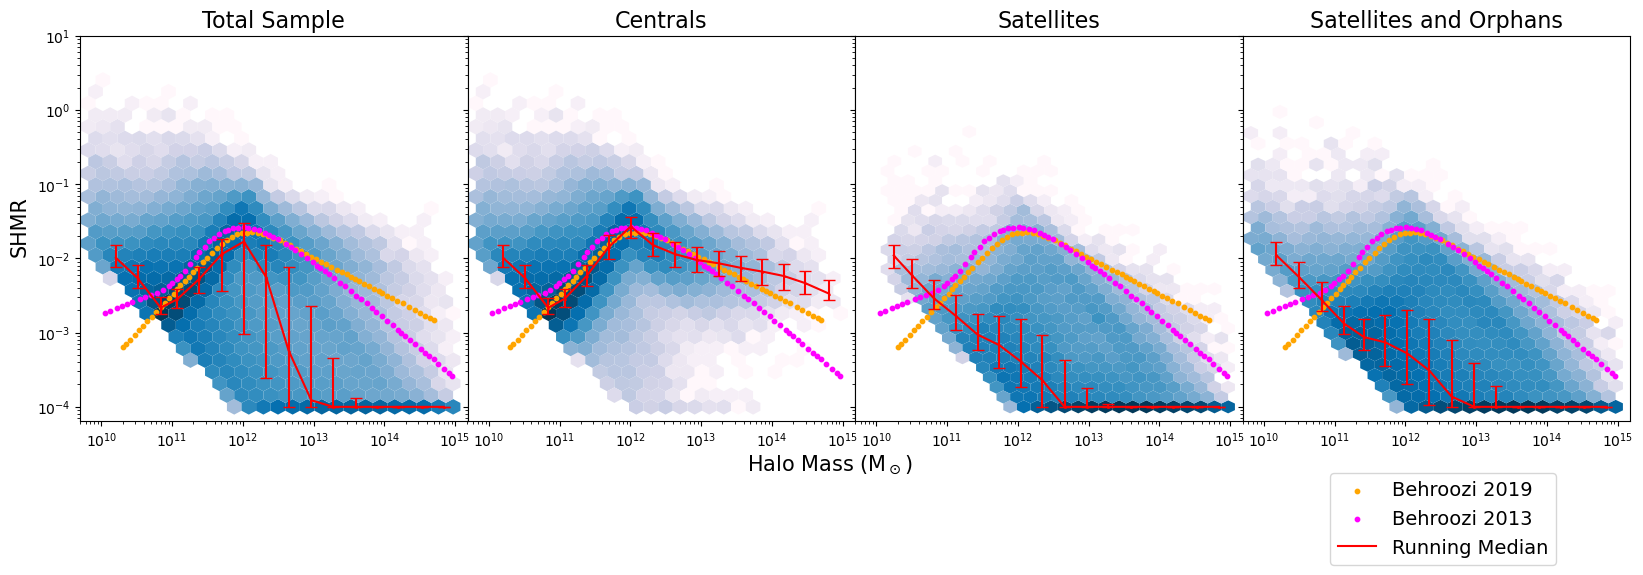

In [10]:
########################################
# Density Plots (SHMR vs Halo Mass)
########################################
# List of datasets for easy iteration
datasets = [("Total Sample", shark_csv), 
            ("Centrals", shark_csv_centrals), 
            ("Satellites", shark_csv_satellites), 
            ("Satellites and Orphans", shark_csv_satANDor)]

SHMR_threshold = 10**-4

# Create a 1x4 grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.subplots_adjust(wspace=0)

# Set a shared x and y-axis range
y_min = 6.5*10**-5
y_max = 10
x_min = 5*10**9
x_max = 1.5*10**15

# Apply this range and ticks to all subplots
for ax in axs:
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([x_min, x_max])
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())  # Use scalar format for readability

# Loop through each dataset and create a plot
for i, (title, data) in enumerate(datasets):

    SHMR = data['Mstar_all'] / data['Mhalo_host']
    SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)
    
    # Calculate min and max log values of Mhalo_host
    lowLog = math.log10(data['Mhalo_host'].min())
    highLog = math.log10(data['Mhalo_host'].max())

    # Round to the nearest whole number for log binning
    lowLog = round(lowLog, 0)
    highLog = round(highLog, 0)

    # Create log bins
    num_bins = 16
    logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

    # MEDIAN for y-values
    result = binned_statistic(data['Mhalo_host'], SHMR, statistic='median', bins=logBins)
    bin_medians = result.statistic

    # Calculate xVals by finding the median Mhalo_host value within each bin
    xVals = []
    for j in range(len(logBins) - 1):
        # Filter data points within the current bin
        bin_data = data['Mhalo_host'][(data['Mhalo_host'] >= logBins[j]) & (data['Mhalo_host'] < logBins[j+1])]
        if len(bin_data) > 0:
            # Append the median of Mhalo_host values in the bin to xVals
            xVals.append(np.median(bin_data))
        else:
            # If no data points in the bin, append NaN or skip
            xVals.append(np.nan)

    # Convert xVals to a numpy array and remove NaN values (if necessary)
    xVals = np.array(xVals)
    valid_bins = ~np.isnan(xVals)
    xVals = xVals[valid_bins]
    bin_medians = bin_medians[valid_bins]

    # PERCENTILES
    # 25th percentile
    percentile_25 = binned_statistic(data['Mhalo_host'], SHMR, statistic=lambda values: np.percentile(values, 25), bins=logBins)
    p25 = percentile_25.statistic[valid_bins]
    # 75th percentile
    percentile_75 = binned_statistic(data['Mhalo_host'], SHMR, statistic=lambda values: np.percentile(values, 75), bins=logBins)
    p75 = percentile_75.statistic[valid_bins]

    # Plot on the current subplot
    axs[i].hexbin(data['Mhalo_host'], SHMR, gridsize=25, xscale='log', yscale='log',
                       reduce_C_function=np.sum, mincnt=1, bins='log', linewidth=0, cmap='PuBu')
    axs[i].scatter(SHMRline["Column1"], SHMRline["Column2"], color='orange', s=10, label='Behroozi 2019') #BEHROOZI 2019
    axs[i].scatter(SHMRline2["Column1"], SHMRline2["Column2"], color='magenta', s=10, label='Behroozi 2013') #BEHROOZI 2013
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlim([x_min, x_max])
    axs[i].set_ylim([y_min, y_max])

    # Bin plotting
    axs[i].scatter(xVals, bin_medians, s=1, color='red', marker="^")
    axs[i].plot(xVals, bin_medians, color='red', linestyle='-', linewidth=1.5, label='Running Median')
    axs[i].errorbar(xVals, bin_medians, yerr=[bin_medians - p25, p75 - bin_medians], fmt='none', ecolor='red', capsize=4)

    # Set titles and remove y-axis labels for intermediate plots
    axs[i].set_title(f'{title}', fontsize=16)

# Add a single x-axis and y-axis label
fig.text(0.5, 0.01, r'Halo Mass (M$_\odot$)', ha='center', fontsize=15)
fig.text(0.09, 0.5, 'SHMR', va='center', rotation='vertical', fontsize=15)

plt.legend(loc="lower left", bbox_to_anchor = (0.2,-0.4), fontsize = 14)
plt.show()

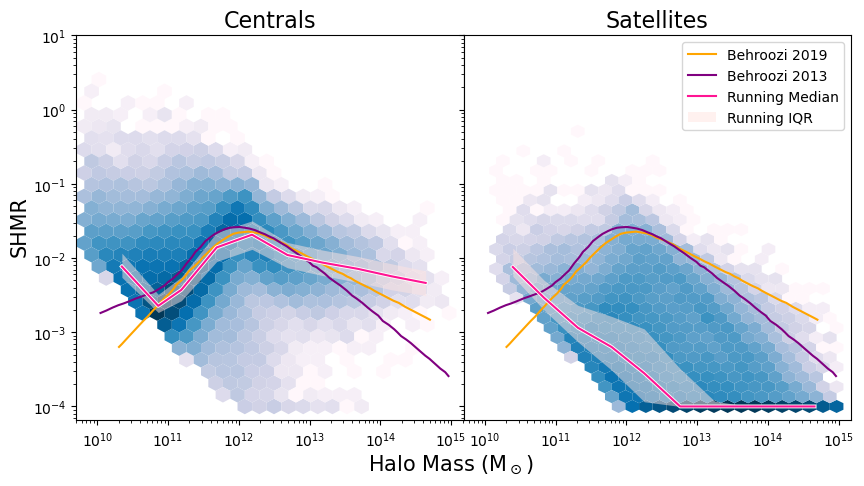

In [11]:
########################################
# Density Plots (SHMR vs Halo Mass) Centrals and Satellites only
########################################
# List of datasets for easy iteration
datasets = [("Centrals", shark_csv_centrals), 
            ("Satellites", shark_csv_satellites)]

SHMR_threshold = 10**-4

# Create a 1x4 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
fig.subplots_adjust(wspace=0)

# Set a shared x and y-axis range
y_min = 6.5*10**-5
y_max = 10
x_min = 5*10**9
x_max = 1.5*10**15

# Apply this range and ticks to all subplots
for ax in axs:
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([x_min, x_max])
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())  # Use scalar format for readability

# Loop through each dataset and create a plot
for i, (title, data) in enumerate(datasets):

    SHMR = data['Mstar_all'] / data['Mhalo_host']
    SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)
    
    # Calculate min and max log values of Mhalo_host
    lowLog = math.log10(data['Mhalo_host'].min())
    highLog = math.log10(data['Mhalo_host'].max())

    # Round to the nearest whole number for log binning
    lowLog = round(lowLog, 0)
    highLog = round(highLog, 0)

    # Create log bins
    num_bins = 10
    logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

    # MEDIAN for y-values
    result = binned_statistic(data['Mhalo_host'], SHMR, statistic='median', bins=logBins)
    bin_medians = result.statistic

    # Calculate xVals by finding the median Mhalo_host value within each bin
    xVals = []
    for j in range(len(logBins) - 1):
        # Filter data points within the current bin
        bin_data = data['Mhalo_host'][(data['Mhalo_host'] >= logBins[j]) & (data['Mhalo_host'] < logBins[j+1])]
        if len(bin_data) > 0:
            # Append the median of Mhalo_host values in the bin to xVals
            xVals.append(np.median(bin_data))
        else:
            # If no data points in the bin, append NaN or skip
            xVals.append(np.nan)

    # Convert xVals to a numpy array and remove NaN values (if necessary)
    xVals = np.array(xVals)
    valid_bins = ~np.isnan(xVals)
    xVals = xVals[valid_bins]
    bin_medians = bin_medians[valid_bins]

    # PERCENTILES
    # 25th percentile
    percentile_25 = binned_statistic(data['Mhalo_host'], SHMR, statistic=lambda values: np.percentile(values, 25), bins=logBins)
    p25 = percentile_25.statistic[valid_bins]
    # 75th percentile
    percentile_75 = binned_statistic(data['Mhalo_host'], SHMR, statistic=lambda values: np.percentile(values, 75), bins=logBins)
    p75 = percentile_75.statistic[valid_bins]

    # Plot on the current subplot
    axs[i].hexbin(data['Mhalo_host'], SHMR, gridsize=25, xscale='log', yscale='log',
                       reduce_C_function=np.sum, mincnt=1, bins='log', linewidth=0, cmap='PuBu')
    axs[i].plot(SHMRline["Column1"], SHMRline["Column2"], linewidth=1.5,color='orange', label='Behroozi 2019') #BEHROOZI 2019
    axs[i].plot(SHMRline2["Column1"], SHMRline2["Column2"], linewidth=1.5,color='purple',label='Behroozi 2013') #BEHROOZI 2013
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlim([x_min, x_max])
    axs[i].set_ylim([y_min, y_max])

    # Bin plotting
    axs[i].plot(xVals, bin_medians, color='white', linestyle='-', linewidth=2.8)
    axs[i].plot(xVals, bin_medians, color='deeppink', linestyle='-', linewidth=1.5, label='Running Median')
    axs[i].fill_between(xVals, p25, p75, color='mistyrose', alpha=0.5, label='Running IQR', linewidth=0)

    # Set titles and remove y-axis labels for intermediate plots
    axs[i].set_title(f'{title}', fontsize=16)

# Add a single x-axis and y-axis label
fig.text(0.5, 0.01, r'Halo Mass (M$_\odot$)', ha='center', fontsize=15)
fig.text(0.059, 0.5, 'SHMR', va='center', rotation='vertical', fontsize=15)

plt.legend(loc="upper right", fontsize = 10)
plt.show()

xVals: [1.60405861e+10 3.27358921e+10 6.90727270e+10 1.17849207e+11
 2.40608808e+11 4.94639294e+11 1.01579470e+12 2.07987480e+12
 4.27759869e+12 8.71625810e+12 1.77410532e+13 3.62468167e+13
 7.35778588e+13 1.47089898e+14 2.94630354e+14 6.39138419e+14]
bin_medians: [0.01013983 0.0053878  0.0021602  0.00285382 0.00578228 0.0141957
 0.02694881 0.01515239 0.01142444 0.00951415 0.00859169 0.00746539
 0.00663614 0.00579824 0.0046551  0.00336142]


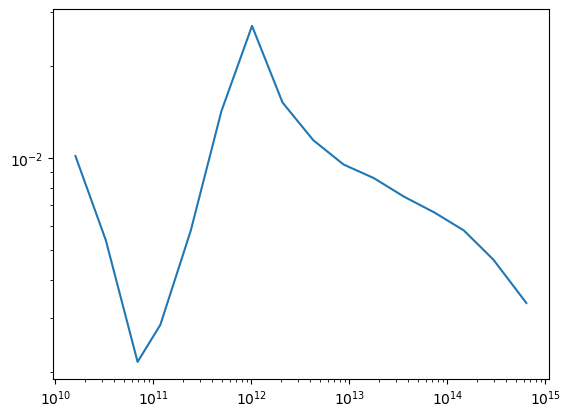

In [12]:
########################################
# Residual line - HALO MASS vs. SHMR
########################################
SHMR_threshold = 10**-4
SHMR = shark_csv_centrals['Mstar_all'] / shark_csv_centrals['Mhalo_host']
SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)

# Calculate min and max log values of Mhalo_host for centrals
lowLog = math.log10(shark_csv_centrals['Mhalo_host'].min())
highLog = math.log10(shark_csv_centrals['Mhalo_host'].max())

# Round to the nearest whole number for log binning
lowLog = round(lowLog, 0)
highLog = round(highLog, 0)

# Create log bins
num_bins = 16
logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

# MEDIAN for y-values (SHMR) using centrals data
result = binned_statistic(
    shark_csv_centrals['Mhalo_host'],
    SHMR,  # Replace 'SHMR' with the appropriate column name for your y-values
    statistic='median',
    bins=logBins
)
bin_medians = result.statistic

# Calculate xVals by finding the median Mhalo_host value within each bin
xVals = []
for j in range(len(logBins) - 1):
    # Filter data points within the current bin
    bin_data = shark_csv_centrals['Mhalo_host'][
        (shark_csv_centrals['Mhalo_host'] >= logBins[j]) & 
        (shark_csv_centrals['Mhalo_host'] < logBins[j + 1])
    ]
    if len(bin_data) > 0:
        # Append the median of Mhalo_host values in the bin to xVals
        xVals.append(np.median(bin_data))
    else:
        # If no data points in the bin, append NaN
        xVals.append(np.nan)

# Convert xVals to a numpy array and remove NaN values (if necessary)
xVals = np.array(xVals)
valid_bins = ~np.isnan(xVals)
xVals = xVals[valid_bins]
bin_medians = bin_medians[valid_bins]

print('xVals:', xVals)
print('bin_medians:', bin_medians)
########################################

plt.plot(xVals, bin_medians)
plt.xscale('log')
plt.yscale('log')

xVals: [1.38982090e+08 2.83701655e+08 5.83810499e+08 1.19686366e+09
 2.45753795e+09 5.11971469e+09 1.07303786e+10 2.24411164e+10
 4.24713601e+10 8.42102974e+10 1.76227514e+11 3.56661925e+11
 7.47678206e+11 1.55997107e+12 2.77950214e+12 6.44679850e+12]
bin_medians: [0.00199204 0.00278511 0.003953   0.00566845 0.00828632 0.01253102
 0.01821338 0.02285484 0.02814125 0.02034436 0.0138895  0.01222676
 0.01092865 0.01341789 0.01105616 0.01858308]


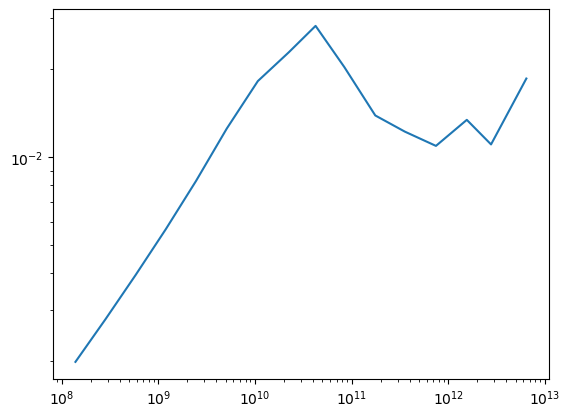

In [13]:
########################################
# Residual line - STELLAR MASS vs. SHMR
########################################
SHMR_threshold = 10**-4
SHMR = shark_csv_centrals['Mstar_all'] / shark_csv_centrals['Mhalo_host']
SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)

# Calculate min and max log values of Mstar_all for centrals
lowLog = math.log10(shark_csv_centrals['Mstar_all'].min())
highLog = math.log10(shark_csv_centrals['Mstar_all'].max())

# Round to the nearest whole number for log binning
lowLog = round(lowLog, 0)
highLog = round(highLog, 0)

# Create log bins
num_bins = 16
logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

# MEDIAN for y-values (SHMR) using centrals data
result = binned_statistic(
    shark_csv_centrals['Mstar_all'],
    SHMR,  # Replace 'SHMR' with the appropriate column name for your y-values
    statistic='median',
    bins=logBins
)
bin_medians = result.statistic

# Calculate xVals by finding the median Mstar_all value within each bin
xVals = []
for j in range(len(logBins) - 1):
    # Filter data points within the current bin
    bin_data = shark_csv_centrals['Mstar_all'][
        (shark_csv_centrals['Mstar_all'] >= logBins[j]) & 
        (shark_csv_centrals['Mstar_all'] < logBins[j + 1])
    ]
    if len(bin_data) > 0:
        # Append the median of Mstar_all values in the bin to xVals
        xVals.append(np.median(bin_data))
    else:
        # If no data points in the bin, append NaN
        xVals.append(np.nan)

# Convert xVals to a numpy array and remove NaN values (if necessary)
xVals = np.array(xVals)
valid_bins = ~np.isnan(xVals)
xVals = xVals[valid_bins]
bin_medians = bin_medians[valid_bins]

print('xVals:', xVals)
print('bin_medians:', bin_medians)
########################################

plt.plot(xVals, bin_medians)
plt.xscale('log')
plt.yscale('log')